In [1]:
# **Шаг 1: Установка и импорт библиотек**
# Устанавливаем необходимые библиотеки
!pip install bertopic
!pip install sentence-transformers
!pip install hdbscan
!pip install umap-learn
!pip install datasets


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Импортируем библиотеки
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import numpy as np
import umap
import hdbscan
import matplotlib.pyplot as plt

C:\Users\KVladimirov\PycharmProjects\bot_exhibition_guide\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import json
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForMaskedLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling, pipeline
from datasets import Dataset
import pandas as pd
from tabulate import tabulate

In [3]:
# Рассчитываем среднюю длину текста в каждом из столбцов (название, описание, автор)
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KVladimirov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\KVladimirov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [9]:
!nvidia-smi

"nvidia-smi" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [4]:
artefact_catalog_df = pd.read_csv("../data/processed/cleaned_dataset.csv")

In [5]:
artefact_catalog_df.shape

(33448, 10)

In [6]:
artefact_catalog_df.head()

,title,authors,creation_time,size,technique,collection,exhibition,description,url,cleaned_description
0,Бриг «Меркурий»,"['Айвазовский И.К.', 'Айвазовский И.К.']",1848,"123,5x190 см","Холст, масло",Государственный Русский музей,Иван Константинович Айвазовский,И.К. Айвазовский Бриг «Меркурий» после победы ...,https://ar.culture.ru/ru/subject/brig-merkuriy-1,ик айвазовский бриг меркурий победы двумя туре...
1,Буря у мыса Айя,"['Айвазовский И.К.', 'Айвазовский И.К.']",1875,215x325 см,"Холст, масло",Государственный Русский музей,Иван Константинович Айвазовский,И.К. Айвазовский Буря у мыса Айя Картина писал...,https://ar.culture.ru/ru/subject/burya-u-mysa-...,ик айвазовский буря мыса айя картина писалась ...
2,Подружки,"['Сычков Ф.В.', 'Сычков Ф.В.']",1909 год,"86,8x57,5 см","Холст, масло",Ярославский художественный музей,Три века русской живописи,Сычков Ф. В. Подружки О картине Картину «Подру...,https://ar.culture.ru/ru/subject/podruzhki,сычков ф подружки картине картину подружки фед...
3,Аллегория бренности,"['Петер ван дер Виллиге', 'Петер ван дер Вилли...",вторая половина XVII века,111x85 см,"холст, масло",ГМИИ им. А.С. Пушкина,Предмет – Образ – Смысл,Виллиге Петер ван дер Аллегория бренности Карт...,https://ar.culture.ru/ru/subject/allegoriya-br...,виллиге петер ван дер аллегория бренности карт...
4,Березовая роща,"['Шишкин И.И.', 'Шишкин И.И.']",1896 год,"105,8x69,8 см","Холст, масло",Ярославский художественный музей,Три века русской живописи,Шишкин И.И. Березовая роща О картине Иван Шишк...,https://ar.culture.ru/ru/subject/berezovaya-ro...,шишкин ии березовая роща картине иван шишкин н...


# Инициализация модели BERTopic

In [7]:
output_dir = "../models/bert_model/fine_tuned_model"
embedding_model = SentenceTransformer(output_dir)

No sentence-transformers model found with name ../models/bert_model/fine_tuned_model. Creating a new one with mean pooling.
Some weights of BertModel were not initialized from the model checkpoint at ../models/bert_model/fine_tuned_model and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Дообучение BERTopic на эмбеддингах

## Извлечение текстов из колонки 'description'

In [9]:
docs = artefact_catalog_df['description'].tolist()
cleaned_docs = artefact_catalog_df['cleaned_description'].tolist()
print(f"Количество текстов: {len(docs)}")

Количество текстов: 33448


## Генерация эмбеддингов для текстов с дообученной моделью

In [10]:
embeddings = embedding_model.encode(docs, show_progress_bar=True)

Batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1046/1046 [1:00:41<00:00,  3.48s/it]


In [13]:
embeddings.shape

(33448, 384)

In [12]:
file_path = "../data/processed/embeddings_and_indices.npz"
np.savez(file_path, embeddings=embeddings)

In [33]:
file_path = "../data/processed/embeddings_and_indices.npz"
embeddings = np.load(file_path)
embeddings = embeddings["embeddings"]

## Визуализация процесса обучения

In [43]:
print("Проекция эмбеддингов в 2D...")
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=42)
embeddings_2d = reducer.fit_transform(embeddings)

Проекция эмбеддингов в 2D...


In [44]:
# Кластеризация с помощью HDBSCAN
print("Кластеризация эмбеддингов...")
clusterer = hdbscan.HDBSCAN(min_cluster_size=30, prediction_data=True, cluster_selection_epsilon=0.04)
# clusterer = hdbscan.HDBSCAN(min_cluster_size=10, prediction_data=True)
clusters = clusterer.fit_predict(embeddings_2d)

Кластеризация эмбеддингов...


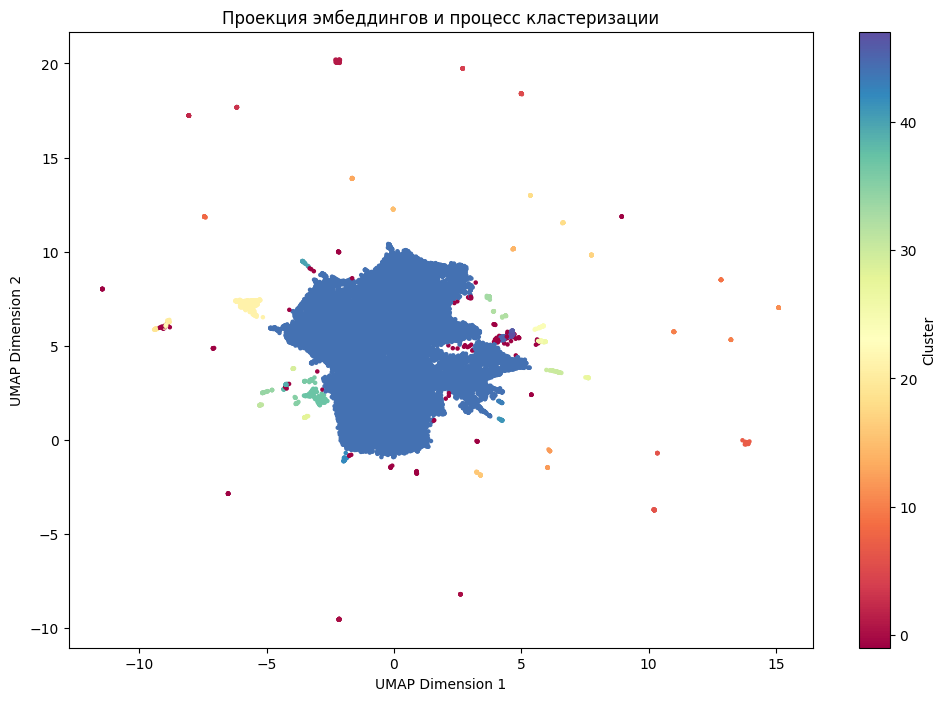

In [45]:
# Визуализация UMAP + HDBSCAN
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='Spectral', s=5)
plt.title("Проекция эмбеддингов и процесс кластеризации")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(label="Cluster")
plt.show()

## Создание модели BERTopic

In [255]:
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=30, prediction_data=True, cluster_selection_epsilon=0.04)

topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=hdbscan_model, calculate_probabilities=True)

## Обучение BERTopic с предобученными эмбеддингами

In [256]:
%%time

print("Обучение BERTopic...")
topics, probs = topic_model.fit_transform(cleaned_docs, embeddings=embeddings)

Обучение BERTopic...
CPU times: total: 4min 13s
Wall time: 44.2 s


# Анализ тем

## Получение информации о выделенных темах

In [258]:
topic_info = topic_model.get_topic_info()
print("Информация о темах:")
print(topic_info[["Topic", "Count", "Name"]])

Информация о темах:
    Topic  Count                                               Name
0      -1  10498                 -1_году_года_культуры_министерство
1       0   9280                      0_художник_году_художника_это
2       1   5759                        1_века_культуры_это_которые
3       2   1602                        2_икона_иконы_церкви_христа
4       3    830                   3_года_войны_армии_отечественной
5       4    614                          4_войны_армии_оружия_года
6       5    425                 5_рф_министерство_культуры_шахматы
7       6    379              6_реставрации_реставрация_утраты_слоя
8       7    346          7_фотоаппарат_мотоцикл_мотоциклов_аппарат
9       8    324                    8_рф_министерство_культуры_ак12
10      9    308   9_источник_нумизматического_международного_клуба
11     10    262                         10_города_году_здание_года
12     11    241                   11_чучело_саамская_чашка_праотец
13     12    206            

In [259]:
topic_info["Name"].tolist()

['-1_году_года_культуры_министерство',
 '0_художник_году_художника_это',
 '1_века_культуры_это_которые',
 '2_икона_иконы_церкви_христа',
 '3_года_войны_армии_отечественной',
 '4_войны_армии_оружия_года',
 '5_рф_министерство_культуры_шахматы',
 '6_реставрации_реставрация_утраты_слоя',
 '7_фотоаппарат_мотоцикл_мотоциклов_аппарат',
 '8_рф_министерство_культуры_ак12',
 '9_источник_нумизматического_международного_клуба',
 '10_города_году_здание_года',
 '11_чучело_саамская_чашка_праотец',
 '12_росфото_названия_портрет_смит',
 '13_картина_бажова_сказа_павки',
 '14_рф_министерство_культуры_лев',
 '15_гс_победы_райшев_гхмак',
 '16_рф_министерство_икона_культуры',
 '17_краеведческий_музей_районный_интинский',
 '18_года_власти_ссср_совета',
 '19_сражение_наполеон_армии_наполеона',
 '20_министерство_рф_культуры_пн',
 '21_году_святого_участвовал_года',
 '22_рф_министерство_культуры_портрет',
 '23_langru_моне_зал_дворца',
 '24_рф_министерство_культуры_александрович',
 '25_мккк_германия_детям_лагерь'

## Визуализация топ-10 тем с количеством текстов и названиями тем

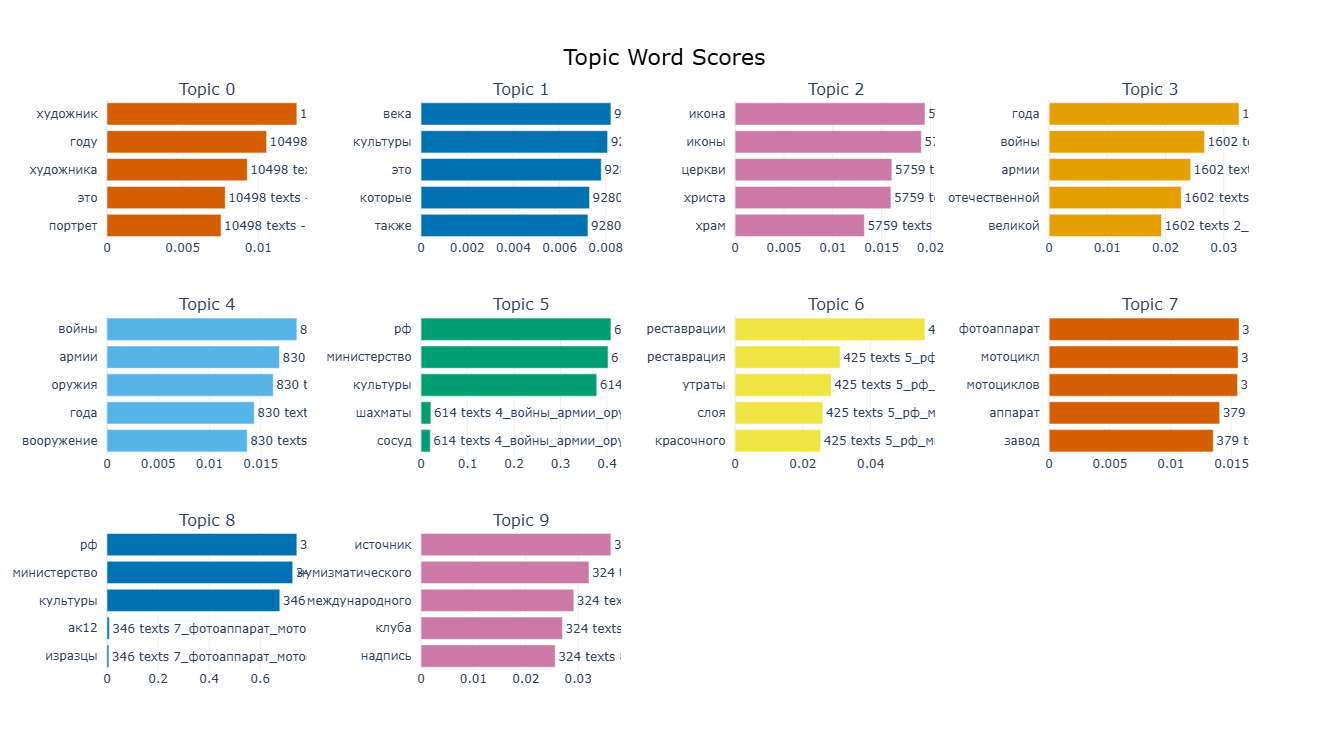

In [260]:
fig = topic_model.visualize_barchart(top_n_topics=10)
for i, bar in enumerate(fig.data):
    bar.text = f"{topic_info.iloc[i]['Count']} texts\n{topic_info.iloc[i]['Name']}"
fig.show()

## Визуализация распределения тем в 2D-пространстве

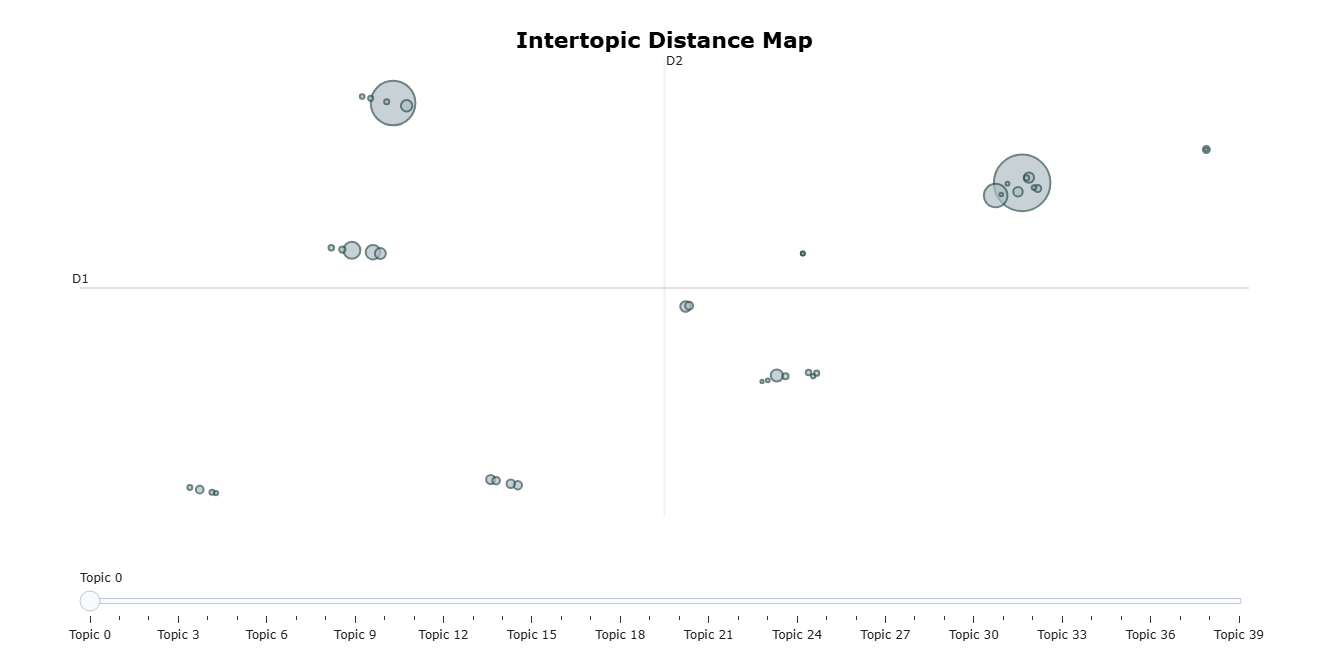

In [261]:
visual_topics = topic_model.visualize_topics()
visual_topics.show()

# Генерация и обновление названий тем

In [262]:
topic_names = topic_model.generate_topic_labels()
print("Сгенерированные названия тем:")
print(topic_names)

Сгенерированные названия тем:
['-1_году_года_культуры', '0_художник_году_художника', '1_века_культуры_это', '2_икона_иконы_церкви', '3_года_войны_армии', '4_войны_армии_оружия', '5_рф_министерство_культуры', '6_реставрации_реставрация_утраты', '7_фотоаппарат_мотоцикл_мотоциклов', '8_рф_министерство_культуры', '9_источник_нумизматического_международного', '10_города_году_здание', '11_чучело_саамская_чашка', '12_росфото_названия_портрет', '13_картина_бажова_сказа', '14_рф_министерство_культуры', '15_гс_победы_райшев', '16_рф_министерство_икона', '17_краеведческий_музей_районный', '18_года_власти_ссср', '19_сражение_наполеон_армии', '20_министерство_рф_культуры', '21_году_святого_участвовал', '22_рф_министерство_культуры', '23_langru_моне_зал', '24_рф_министерство_культуры', '25_мккк_германия_детям', '26_геологии_газа_нефти', '27_кристаллов_см_кристаллы', '28_господарик_мышкина_ва', '29_году_блохин_года', '30_кириллобелозерский_музейзаповедник_акафист', '31_дерябин_михайлович_владимир', '

In [263]:
# Обновление названий тем
for i, name in enumerate(topic_names):
    print(f"Тема {i}: {name}")

topic_model.set_topic_labels(topic_names)

Тема 0: -1_году_года_культуры
Тема 1: 0_художник_году_художника
Тема 2: 1_века_культуры_это
Тема 3: 2_икона_иконы_церкви
Тема 4: 3_года_войны_армии
Тема 5: 4_войны_армии_оружия
Тема 6: 5_рф_министерство_культуры
Тема 7: 6_реставрации_реставрация_утраты
Тема 8: 7_фотоаппарат_мотоцикл_мотоциклов
Тема 9: 8_рф_министерство_культуры
Тема 10: 9_источник_нумизматического_международного
Тема 11: 10_города_году_здание
Тема 12: 11_чучело_саамская_чашка
Тема 13: 12_росфото_названия_портрет
Тема 14: 13_картина_бажова_сказа
Тема 15: 14_рф_министерство_культуры
Тема 16: 15_гс_победы_райшев
Тема 17: 16_рф_министерство_икона
Тема 18: 17_краеведческий_музей_районный
Тема 19: 18_года_власти_ссср
Тема 20: 19_сражение_наполеон_армии
Тема 21: 20_министерство_рф_культуры
Тема 22: 21_году_святого_участвовал
Тема 23: 22_рф_министерство_культуры
Тема 24: 23_langru_моне_зал
Тема 25: 24_рф_министерство_культуры
Тема 26: 25_мккк_германия_детям
Тема 27: 26_геологии_газа_нефти
Тема 28: 27_кристаллов_см_кристаллы
Те

# Сохранение результатов

In [265]:
# Добавление результатов в DataFrame
artefact_catalog_df['topic'] = topics

# Сохранение результата в CSV-файл
artefact_catalog_df.to_csv("../data/processed/docs_topics.csv", index=False)

In [267]:
# Сохранение модели BERTopic
topic_model.save("../models/bertopic_model/bertopic_model.pkl")
print("Результаты и модель сохранены.")

2024-12-18 17:02:03,767 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


Результаты и модель сохранены.


# Проверка на тестовом запросе

## Плохой пример запроса от пользователя

In [268]:
query = "Запрос пользователя на интересующую тему"
query_embedding = embedding_model.encode([query], show_progress_bar=True)
cleaned_query = clean_text(query)
query_topic, _ = topic_model.transform([query], embeddings=np.array(query_embedding))

print(f"Запрос относится к теме: {query_topic}")

Batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.87it/s]

Запрос относится к теме: [np.int64(0)]


## Хороший пример запроса от пользователя

In [271]:
query = """Российская академия художеств и Московский государственный академический художественный институт имени В.И. Сурикова при РАХ представляют выставочный проект, приуроченный к 30-летию мастерской Николая Андронова (1929-1998), Павла Никонова и Юрия Шишкова (1940-2020).
Провокационное название выставки «Право на ошибку», демонстрирующей около 150 живописных полотен и графических листов, обнажает множество скрытых тем и идей, неизбежно приводящих к выводу не только о допустимости, но даже о необходимости совершения ошибочных действий в творчестве. Именно это способствует поиску и, что важнее, обретению истинности художественного решения, когда процесс, а не результат, становится самоцелью. В экспозиции будут представлены произведения классика отечественной живописи, народного художника РФ и академика Российской академии художеств Павла Фёдоровича Никонова, заслуженного художника РФ и академика РАХ Юрия Алексеевича Шишкова, а также работы более 20 учеников и выпускников мастерской, среди которых: Виталий Беспятый, Павел Боркунов, Евгения Буравлёва, Елена Бурыкина-Никонова, Ольга Гавришева, Елена Гостюшина, Дмитрий Грачёв, Ольга Гуревич, Айсулу Кадыржанова, Екатерина Клочкова, Евгения Косушкина, Дарья Котлярова, Никита Кулинич, Галина Логвиненко, Владимир Онищук, Павел Отдельнов, Егор Плотников, Ирина Привознова, Полина Рыбакова, Михаил Смирнов, Айгерим Сыздыкова, Роман Усачёв, Ирина Филатова, Елена Цицулина, Татьяна Чурсина, Руслан Ямбушев и Юлия Эрдни Араева.
"""
query_embedding = embedding_model.encode([query], show_progress_bar=True)
cleaned_query = clean_text(query)
query_topic, _ = topic_model.transform([query], embeddings=np.array(query_embedding))

print(f"Запрос относится к теме: {query_topic}")

Batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]

Запрос относится к теме: [np.int64(35)]


In [278]:
topic_info[topic_info["Topic"] == query_topic[0]].T

,Topic,Count,Name,CustomName,Representation,Representative_Docs
36,35,42,35_леф_родченко_брика_пролеткультовцы,35_леф_родченко_брика,"[леф, родченко, брика, пролеткультовцы, чужак,...",[группа леф левый фронт искусств возникла году...
